In [67]:
#投資組合1
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt


parser= lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
retData = pd.read_csv('retData1.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser,
                      usecols=['Date', 'SPY','EWJ','EWC','EWG','50','51'])

#use SPY as benchmark
benchmark = pd.read_csv('retData1.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser,
                      usecols=['Date','SPY'])
benchmark = benchmark['2016-04-01':'2016-12-30']
benchmark =cumreturn=(1+benchmark).cumprod()-1

cumreturn=(1+retData).cumprod()-1
cumreturn.plot()
plt.title('Cumulative Return of 6 stocks(2016)')
plt.legend(loc='lower center',bbox_to_anchor=(0.5,-0.3),
          ncol=5,fancybox=True,shadow=True)

retData=retData.dropna()
retData.corr()


,SPY,EWJ,EWC,EWG,50,51
SPY,1.000000,0.702562,0.750826,0.796367,0.021428,0.086329
EWJ,0.702562,1.000000,0.593888,0.649313,-0.009905,0.009740
EWC,0.750826,0.593888,1.000000,0.689132,0.101356,0.067558
EWG,0.796367,0.649313,0.689132,1.000000,0.062564,0.034219
50,0.021428,-0.009905,0.101356,0.062564,1.000000,0.467408
51,0.086329,0.009740,0.067558,0.034219,0.467408,1.000000


In [68]:
import portfolioopt as pfopt
import numpy as np

train_set=retData['2016-01-04':'2016-03-31']
test_set=retData['2016-04-01':'2016-12-30']
cov_mat=train_set.cov()
avg_rets = train_set.mean()
target_ret=0.0001
weights=pfopt.markowitz_portfolio(cov_mat,avg_rets,target_ret,allow_short=False)

weights

SPY    0.347323
EWJ    0.013773
EWC    0.000170
EWG    0.028406
50     0.525283
51     0.085044
dtype: float64

In [69]:
test_return=np.dot(test_set,np.matrix(weights).T)
test_return=pd.DataFrame(test_return,index=test_set.index)
test_cum_return=(1+test_return).cumprod()-1
test_cum_return.columns=['markowitz_portfolio']
test_cum_return


,markowitz_portfolio
Date,
2016-04-01,0.001414
2016-04-04,-0.004515
2016-04-05,0.000715
2016-04-06,0.004336
2016-04-07,-0.007070
2016-04-08,-0.018615
2016-04-11,-0.021910
2016-04-12,-0.012619
2016-04-13,-0.006465


In [70]:
from scipy import linalg
import numpy as np

def blacklitterment(returns,tau,P,Q):
    mu =returns.mean()
    sigma = returns.cov()
    pil=mu
    ts = tau*sigma
    Omega = np.dot(np.dot(P,ts),P.T)*np.eye(Q.shape[0])
    middle = linalg.inv(np.dot(np.dot(P,ts),P.T)+Omega)
    er = np.expand_dims(pil,axis=0).T+np.dot(np.dot(np.dot(ts,P.T),middle),(Q-np.expand_dims(np.dot(P,pil.T),axis=1)))
    posteriorSigma = sigma + ts-np.dot(ts.dot(P.T).dot(middle).dot(P),ts)
    
    return [er,posteriorSigma]
    
pick1 = np.array([1,-1,0,0,0,0])
q1 = np.array([0.0003])
pick2 = np.array([0,0,1,-1,0,0])
q2 = np.array([0.09])
pick3 = np.array([0,0,0,0,1,-1])
q3 = np.array([0.009])
P = np.array([pick1,pick2,pick3])
Q =np.array([q1,q2,q3])
P
Q

res = blacklitterment(retData,0.1,P,Q)
target_ret2=0.0001
cov_mat2=res[1]
avg_rets2=pd.Series(res[0][:,0],index=retData.columns)
weights2=pfopt.markowitz_portfolio(cov_mat2,avg_rets2,target_ret2,allow_short=False)
weights2



SPY    0.436488
EWJ    0.017709
EWC    0.072148
EWG    0.000091
50     0.404014
51     0.069549
dtype: float64

In [71]:
train_set=retData['2016-01-04':'2016-03-31']
test_set=retData['2016-04-01':'2016-12-30']
test_return2=np.dot(test_set,np.matrix(weights2).T)
test_return2=pd.DataFrame(test_return2,index=test_set.index)
test_cum_return2=(1+test_return2).cumprod()-1
test_cum_return2.columns=['blacklitterment_portfolio']
test_cum_return2


,blacklitterment_portfolio
Date,
2016-04-01,0.001896
2016-04-04,-0.004052
2016-04-05,-0.002044
2016-04-06,0.002983
2016-04-07,-0.008207
2016-04-08,-0.015360
2016-04-11,-0.017776
2016-04-12,-0.007491
2016-04-13,-0.000822


In [72]:
#equally weight

w3 = [0.1667,0.1667,0.1667,0.1667,0.1667,0.1667]
    
weights3 = pd.DataFrame(w3, index = test_set.columns)
test_return3 = np.dot(test_set,
                        np.matrix(weights3))
test_return3 = pd.DataFrame(test_return3, index = test_set.index)
test_cum_return3=(1+test_return3).cumprod()-1
test_cum_return3.columns = ['Equally Weighted']



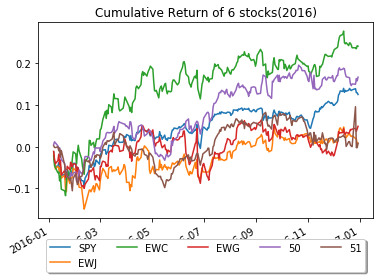

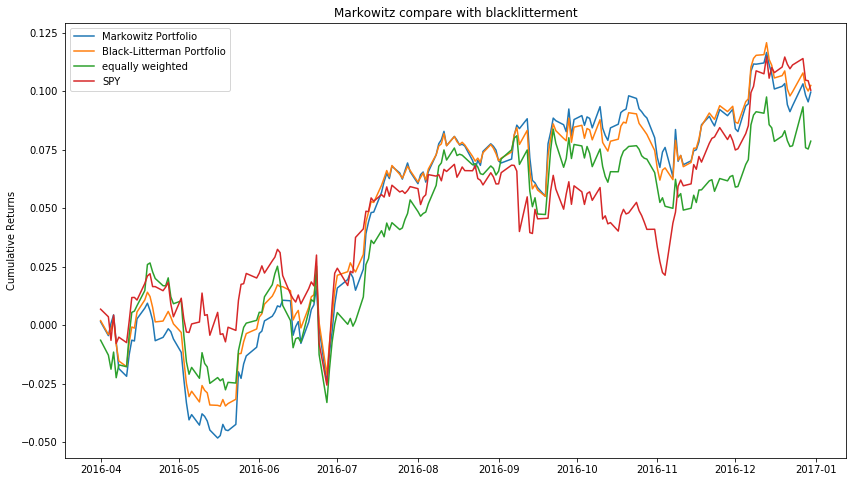

In [73]:
plt.figure(figsize=(14, 8))
plt.plot(test_cum_return.index,test_cum_return)
plt.plot(test_cum_return2.index,test_cum_return2)
plt.plot(test_cum_return3.index,test_cum_return3)
plt.plot(benchmark.index,benchmark)
plt.ylabel('Cumulative Returns')
plt.legend(['Markowitz Portfolio','Black-Litterman Portfolio','equally weighted','SPY'
            ],loc='upper left')
plt.title('Markowitz compare with blacklitterment')
plt.show()